In [287]:
import yfinance as yf
import pandas as pd 
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import talib.abstract as ta
import ta as ta2
import tti
import yfinance as yf
import pandas as pd 
import sklearn.model_selection as sk
import numpy as np
from ignite.engine import Engine, Events
from ignite.handlers import EarlyStopping
import matplotlib.pyplot as plt
import scipy.stats as stats
import os
import random
import numpy as np
import pandas_datareader.data as web
import datetime
from sklearn.metrics import accuracy_score, f1_score, mean_absolute_error

In [288]:
"""freddata = web.DataReader(["DTB4WK","DTB3","DTB6","DGS5","DGS10","DGS3MO","DGS6MO","DGS1","DAAA","DBAA","DCOILWTICO","DCOILBRENTEU"], "fred",start=(pd.Timestamp("2023-09-18")-datetime.timedelta(1))).fillna(method="ffill")
freddata"""

'freddata = web.DataReader(["DTB4WK","DTB3","DTB6","DGS5","DGS10","DGS3MO","DGS6MO","DGS1","DAAA","DBAA","DCOILWTICO","DCOILBRENTEU"], "fred",start=(pd.Timestamp("2023-09-18")-datetime.timedelta(1))).fillna(method="ffill")\nfreddata'

In [289]:
"""from copy import deepcopy as dc
def prepareforlstm(df):
    df["TE1"]=df["DGS10"]-df["DTB4WK"]
    df["TE2"]=df["DGS10"]-df["DTB3"]
    df["TE3"]=df["DGS10"]-df["DTB6"]
    df["TE5"]=df["DTB3"]-df["DTB4WK"]
    df["TE6"]=df["DTB6"]-df["DTB4WK"]
    df["DE1"]=df["DBAA"]-df["DAAA"]
    df["DE2"]=df["DBAA"]-df["DGS10"]
    df["DE4"]=df["DBAA"]-df["DTB6"]
    df["DE5"]=df["DBAA"]-df["DTB3"]
    df["DE6"]=df["DBAA"]-df["DTB4WK"]
    df=dc(df)
    df.dropna(inplace=True)
    return df
fred_change_data=prepareforlstm(freddata)
fred_change_data"""

'from copy import deepcopy as dc\ndef prepareforlstm(df):\n    df["TE1"]=df["DGS10"]-df["DTB4WK"]\n    df["TE2"]=df["DGS10"]-df["DTB3"]\n    df["TE3"]=df["DGS10"]-df["DTB6"]\n    df["TE5"]=df["DTB3"]-df["DTB4WK"]\n    df["TE6"]=df["DTB6"]-df["DTB4WK"]\n    df["DE1"]=df["DBAA"]-df["DAAA"]\n    df["DE2"]=df["DBAA"]-df["DGS10"]\n    df["DE4"]=df["DBAA"]-df["DTB6"]\n    df["DE5"]=df["DBAA"]-df["DTB3"]\n    df["DE6"]=df["DBAA"]-df["DTB4WK"]\n    df=dc(df)\n    df.dropna(inplace=True)\n    return df\nfred_change_data=prepareforlstm(freddata)\nfred_change_data'

In [290]:
"""freddata2=fred_change_data.copy()
freddata2.index=freddata2.index.strftime('%Y-%m-%d 12:00:00')
freddata2"""

"freddata2=fred_change_data.copy()\nfreddata2.index=freddata2.index.strftime('%Y-%m-%d 12:00:00')\nfreddata2"

In [291]:
data = yf.download('GARAN.IS',period="5y",interval="1D")
data=data.rename({"High":"high","Low":"low","Close":"close","Open":"open","Adj Close":"adj close","Volume":"volume"},axis=1)


data["returns"]=data["close"].pct_change()
from copy import deepcopy as dc
def prepareforlstm(df,lookback):
    df['direction'] = np.sign(df['returns'])
    df['momentum'] = df['returns'].rolling(5).mean().shift(1)
    df['volatility'] = df['returns'].rolling(20).std().shift(1)
    df['direction'] = np.where(df['returns'] > 0, 1, 0)
    df['distance'] = (df['close'] - df['close'].rolling(50).mean()).shift(1)
    df["mom1"]=ta.MOM(df["close"],1)
    df["mom1"]=df["mom1"].shift(1)
    df["mom2"]=ta.MOM(df["close"],2)
    df["mom2"]=df["mom2"].shift(1)
    df["mom3"]=ta.MOM(df["close"],3)
    df["mom3"]=df["mom3"].shift(1) 
    df["ema_10"]=ta.EMA(df["close"],10)
    df["ema_10"]=df["ema_10"].shift(1)
    df["ema_20"]=ta.EMA(df["close"],20)
    df["ema_20"]=df["ema_20"].shift(1)
    df["ema_50"]=ta.EMA(df["close"],50)
    df["ema_50"]=df["ema_50"].shift(1)
    df["roc5"]=ta.ROC(df["close"],5)
    df["roc5"]=df["roc5"].shift(1)
    df["roc10"]=ta.ROC(df["close"],10)
    df["roc10"]=df["roc10"].shift(1)
    df["roc15"]=ta.ROC(df["close"],15)
    df["roc15"]=df["roc15"].shift(1)
    df["roc20"]=ta.ROC(df["close"],20)
    df["roc20"]=df["roc20"].shift(1)
    df=dc(df)
    for i in range(1,lookback+1):
        df[f'close(t-{i})']=df["close"].shift(i)
    df.dropna(inplace=True)
    df.drop(["low","high","open","adj close","volume","close","returns"],axis=1,inplace=True)
    
    return df
shifted_df=prepareforlstm(data,7)
shifted_df.info()

[*********************100%%**********************]  1 of 1 completed
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1213 entries, 2018-12-05 to 2023-09-26
Data columns (total 21 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   direction   1213 non-null   int64  
 1   momentum    1213 non-null   float64
 2   volatility  1213 non-null   float64
 3   distance    1213 non-null   float64
 4   mom1        1213 non-null   float64
 5   mom2        1213 non-null   float64
 6   mom3        1213 non-null   float64
 7   ema_10      1213 non-null   float64
 8   ema_20      1213 non-null   float64
 9   ema_50      1213 non-null   float64
 10  roc5        1213 non-null   float64
 11  roc10       1213 non-null   float64
 12  roc15       1213 non-null   float64
 13  roc20       1213 non-null   float64
 14  close(t-1)  1213 non-null   float64
 15  close(t-2)  1213 non-null   float64
 16  close(t-3)  1213 non-null   float64
 17  close(t-4)  1213 non-n

In [292]:
"""data = yf.download('GARAN.IS',period="5y",interval="1D")
data=data.rename({"High":"high","Low":"low","Close":"close","Open":"open","Adj Close":"adj close","Volume":"volume"},axis=1)


data["returns"]=data["close"].pct_change()
from copy import deepcopy as dc
def prepareforlstm(df,lookback):
    df['direction'] = np.where(np.sign(df['returns'])==-1,0,1)
    df['momentum'] = df['returns'].rolling(5).mean().shift(1)
    df['volatility'] = df['returns'].rolling(20).std().shift(1)
    df['distance'] = (df['close'] - df['close'].rolling(50).mean()).shift(1)
    df=dc(df)
    for i in range(1,lookback+1):
        df[f'returns(t-{i})']=df["returns"].shift(i)
    df.dropna(inplace=True)
    df.drop(["low","high","open","adj close","volume","close","returns"],axis=1,inplace=True)
    
    return df
shifted_df=prepareforlstm(data,7)
shifted_df.info()"""

'data = yf.download(\'GARAN.IS\',period="5y",interval="1D")\ndata=data.rename({"High":"high","Low":"low","Close":"close","Open":"open","Adj Close":"adj close","Volume":"volume"},axis=1)\n\n\ndata["returns"]=data["close"].pct_change()\nfrom copy import deepcopy as dc\ndef prepareforlstm(df,lookback):\n    df[\'direction\'] = np.where(np.sign(df[\'returns\'])==-1,0,1)\n    df[\'momentum\'] = df[\'returns\'].rolling(5).mean().shift(1)\n    df[\'volatility\'] = df[\'returns\'].rolling(20).std().shift(1)\n    df[\'distance\'] = (df[\'close\'] - df[\'close\'].rolling(50).mean()).shift(1)\n    df=dc(df)\n    for i in range(1,lookback+1):\n        df[f\'returns(t-{i})\']=df["returns"].shift(i)\n    df.dropna(inplace=True)\n    df.drop(["low","high","open","adj close","volume","close","returns"],axis=1,inplace=True)\n    \n    return df\nshifted_df=prepareforlstm(data,7)\nshifted_df.info()'

In [293]:
shifted_df

,direction,momentum,volatility,distance,mom1,mom2,mom3,ema_10,ema_20,ema_50,...,roc10,roc15,roc20,close(t-1),close(t-2),close(t-3),close(t-4),close(t-5),close(t-6),close(t-7)
Date,,,,,,,,,,,,,,,,,,,,,
2018-12-05,0,0.004662,0.017724,0.455400,-0.170000,-0.220000,-0.060000,8.056265,7.943318,7.584600,...,1.515150,2.290074,1.132077,8.040000,8.210000,8.260000,8.100000,7.950000,7.860000,8.080000
2018-12-06,0,-0.003847,0.018789,0.194000,-0.250000,-0.420000,-0.470000,8.007853,7.928716,7.592655,...,-2.988789,-2.258467,-3.349881,7.790000,8.040000,8.210000,8.260000,8.100000,7.950000,7.860000
2018-12-07,1,-0.009161,0.018482,0.130400,-0.060000,-0.310000,-0.480000,7.957334,7.909791,7.598041,...,-2.889447,-1.277138,-2.398991,7.730000,7.790000,8.040000,8.210000,8.260000,8.100000,7.950000
2018-12-10,0,-0.006902,0.019589,0.365600,0.240000,0.180000,-0.070000,7.959637,7.915525,7.612628,...,-1.116633,0.377830,1.918154,7.970000,7.730000,7.790000,8.040000,8.210000,8.260000,8.100000
2018-12-11,0,-0.008702,0.019311,0.235800,-0.120000,0.120000,0.060000,7.939703,7.909285,7.621936,...,-2.846535,-3.205916,2.480419,7.850000,7.970000,7.730000,7.790000,8.040000,8.210000,8.260000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-20,1,0.002087,0.028738,2.966199,0.450001,0.049999,-0.549999,50.357463,50.348444,46.661050,...,-3.564552,-5.118485,0.623236,50.049999,49.599998,50.000000,50.599998,49.160000,49.560001,50.250000
2023-09-21,1,0.009496,0.029290,4.087800,1.450001,1.900002,1.500000,50.565197,50.458116,46.850812,...,0.097180,0.194550,4.589761,51.500000,50.049999,49.599998,50.000000,50.599998,49.160000,49.560001
2023-09-22,0,0.005579,0.029327,4.296600,0.500000,1.950001,2.400002,50.826070,50.604962,47.052741,...,-0.763362,3.585656,5.050505,52.000000,51.500000,50.049999,49.599998,50.000000,50.599998,49.160000


In [294]:
"""data2=data.copy()
data2.index=data.index.strftime('%Y-%m-%d %H:%M:%S')
data2"""

"data2=data.copy()\ndata2.index=data.index.strftime('%Y-%m-%d %H:%M:%S')\ndata2"

In [295]:
"""data3=pd.concat([data2,freddata2],axis="columns").fillna(method="ffill").dropna()"""

'data3=pd.concat([data2,freddata2],axis="columns").fillna(method="ffill").dropna()'

In [296]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense,Conv1D,MaxPooling1D,Flatten,Convolution1D,Dropout,MaxPooling2D,Conv2D,LeakyReLU
from tensorflow.keras.optimizers.legacy import Adam
from keras.utils import to_categorical


In [297]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [298]:
"""

shifted_df2
split_index=int(len(shifted_df2)*0.80)
split_index2=int(len(shifted_df2)*0.90)
x_train=np.array(shifted_df2.iloc[:split_index,1:]).reshape(-1,shifted_df2.shape[1]-1,1)
x_val=np.array(shifted_df2.iloc[split_index:split_index2,1:]).reshape(-1,shifted_df2.shape[1]-1,1)
x_test=np.array(shifted_df2.iloc[split_index2:,1:]).reshape(-1,shifted_df2.shape[1]-1,1)
y_train=np.array(shifted_df2.iloc[:split_index,0]).reshape(-1,1)
y_val=np.array(shifted_df2.iloc[split_index:split_index2,0]).reshape(-1,1)
y_test=np.array(shifted_df2.iloc[split_index2:,0]).reshape(-1,1)
def set_seeds(seed=100):
    random.seed(seed)
    np.random.seed(seed)

n_steps = x_train.shape[1]
n_features = x_train.shape[2]
gpu_device = tf.config.list_physical_devices('GPU')[0]

with tf.device('/GPU:0'):
    set_seeds()
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=(n_steps, )))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1,activation='sigmoid'))

n_steps = x_train.shape[1]
n_features = x_train.shape[2]
gpu_device = tf.config.list_physical_devices('GPU')[0]

with tf.device('/GPU:0'):
    set_seeds()
    model = Sequential()
    model.add(Conv1D(16, 2, activation='relu',input_shape=x_train.shape))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1,activation='softmax'))
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])
model.fit(x_train,y_train, verbose=0,validation_data=(x_val,y_val), shuffle=False,batch_size=16,epochs=20)
model.evaluate(x_train,y_train)
pred = np.where(model.predict(x_test) > 0.5, 1, 0)
predict=model.predict(x_test)
test=shifted_df2.iloc[split_index2:,:]
test['prediction'] = np.where(pred > 0, 1, -1)
test
hits = pd.DataFrame(np.sign(test["direction"]*test["prediction"])).value_counts()
hits
plt.plot(test["direction"],label="Actual")
plt.plot(test["prediction"],label='predicted')
plt.xlabel("Time")
plt.ylabel("Close")
plt.legend()
plt.show()"""

'\n\nshifted_df2\nsplit_index=int(len(shifted_df2)*0.80)\nsplit_index2=int(len(shifted_df2)*0.90)\nx_train=np.array(shifted_df2.iloc[:split_index,1:]).reshape(-1,shifted_df2.shape[1]-1,1)\nx_val=np.array(shifted_df2.iloc[split_index:split_index2,1:]).reshape(-1,shifted_df2.shape[1]-1,1)\nx_test=np.array(shifted_df2.iloc[split_index2:,1:]).reshape(-1,shifted_df2.shape[1]-1,1)\ny_train=np.array(shifted_df2.iloc[:split_index,0]).reshape(-1,1)\ny_val=np.array(shifted_df2.iloc[split_index:split_index2,0]).reshape(-1,1)\ny_test=np.array(shifted_df2.iloc[split_index2:,0]).reshape(-1,1)\ndef set_seeds(seed=100):\n    random.seed(seed)\n    np.random.seed(seed)\n\nn_steps = x_train.shape[1]\nn_features = x_train.shape[2]\ngpu_device = tf.config.list_physical_devices(\'GPU\')[0]\n\nwith tf.device(\'/GPU:0\'):\n    set_seeds()\n    model = Sequential()\n    model.add(Dense(64, activation=\'relu\', input_shape=(n_steps, )))\n    model.add(Dense(64, activation=\'relu\'))\n    model.add(Dense(1,acti

In [299]:
"""from sklearn.preprocessing import MinMaxScaler,StandardScaler
scalar=StandardScaler()
shifted_df_as_np=scalar.fit_transform(shifted_df)

shifted_df2=pd.DataFrame(shifted_df_as_np,columns=shifted_df.columns.tolist(),index=shifted_df.index)
split_index=int(len(shifted_df2)*0.80)
split_index2=int(len(shifted_df2)*0.90)
x_train=np.array(shifted_df2.iloc[:split_index,1:]).reshape(-1,shifted_df2.shape[1]-1,1)
x_val=np.array(shifted_df2.iloc[split_index:split_index2,1:]).reshape(-1,shifted_df2.shape[1]-1,1)
x_test=np.array(shifted_df2.iloc[split_index2:,1:]).reshape(-1,shifted_df2.shape[1]-1,1)
y_train=np.array(shifted_df2.iloc[:split_index,0]).reshape(-1,1)
y_val=np.array(shifted_df2.iloc[split_index:split_index2,0]).reshape(-1,1)
y_test=np.array(shifted_df2.iloc[split_index2:,0]).reshape(-1,1)
def set_seeds(seed=100):
    random.seed(seed)
    np.random.seed(seed)







with tf.device('/GPU:0'):
    set_seeds()
    model = Sequential()
    model.add(Conv1D(16, x_train.shape[1], activation='relu',input_shape=x_train.shape))
    model.add(Conv1D(16, 3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(16, 3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    Dropout(0.1)
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1,activation='sigmoid'))
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy'])
model.fit(x_train,y_train, verbose=0,shuffle=0,validation_data=(x_val,y_val),batch_size=16,epochs=30)
model.evaluate(x_train,y_train)
pred = np.where(model.predict(x_test) > 0.5, 1, 0)
predict=model.predict(x_test)
test=shifted_df2.iloc[split_index2:,:]
test['prediction'] = np.where(pred > 0, 1, -1)
test
hits = pd.DataFrame(np.sign(test["direction"]*test["prediction"])).value_counts()
hits
plt.plot(test["direction"],label="Actual")
plt.plot(test["prediction"],label='predicted')
plt.xlabel("Time")
plt.ylabel("Close")
plt.legend()
plt.show()"""

'from sklearn.preprocessing import MinMaxScaler,StandardScaler\nscalar=StandardScaler()\nshifted_df_as_np=scalar.fit_transform(shifted_df)\n\nshifted_df2=pd.DataFrame(shifted_df_as_np,columns=shifted_df.columns.tolist(),index=shifted_df.index)\nsplit_index=int(len(shifted_df2)*0.80)\nsplit_index2=int(len(shifted_df2)*0.90)\nx_train=np.array(shifted_df2.iloc[:split_index,1:]).reshape(-1,shifted_df2.shape[1]-1,1)\nx_val=np.array(shifted_df2.iloc[split_index:split_index2,1:]).reshape(-1,shifted_df2.shape[1]-1,1)\nx_test=np.array(shifted_df2.iloc[split_index2:,1:]).reshape(-1,shifted_df2.shape[1]-1,1)\ny_train=np.array(shifted_df2.iloc[:split_index,0]).reshape(-1,1)\ny_val=np.array(shifted_df2.iloc[split_index:split_index2,0]).reshape(-1,1)\ny_test=np.array(shifted_df2.iloc[split_index2:,0]).reshape(-1,1)\ndef set_seeds(seed=100):\n    random.seed(seed)\n    np.random.seed(seed)\n\n\n\n\n\n\n\nwith tf.device(\'/GPU:0\'):\n    set_seeds()\n    model = Sequential()\n    model.add(Conv1D(16, 

In [300]:
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences.iloc[i:end_ix, 1:], sequences.iloc[end_ix-1, 0]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y).reshape(-1,1)

In [301]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler
scalar=MinMaxScaler(feature_range=(0,1))
shifted_df_as_np=scalar.fit_transform(shifted_df.iloc[:,1:])

shifted_df2=pd.DataFrame(shifted_df_as_np,columns=shifted_df.columns.tolist()[1:],index=shifted_df.index)
n_steps = 5
# convert into input/output
X, Y = split_sequences(pd.concat([shifted_df["direction"],shifted_df2],axis=1), n_steps)


In [302]:
X

array([[[0.60888729, 0.14396518, 0.28192839, ..., 0.02997165,
         0.02814906, 0.0326043 ],
        [0.54182549, 0.16102045, 0.27196946, ..., 0.03300933,
         0.02997165, 0.02814906],
        [0.49994397, 0.15610186, 0.2695464 , ..., 0.0362495 ,
         0.03300933, 0.02997165],
        [0.51774747, 0.17384235, 0.27850714, ..., 0.03523694,
         0.0362495 , 0.03300933],
        [0.50355615, 0.16938471, 0.27356197, ..., 0.03179425,
         0.03523694, 0.0362495 ]],

       [[0.54182549, 0.16102045, 0.27196946, ..., 0.03300933,
         0.02997165, 0.02814906],
        [0.49994397, 0.15610186, 0.2695464 , ..., 0.0362495 ,
         0.03300933, 0.02997165],
        [0.51774747, 0.17384235, 0.27850714, ..., 0.03523694,
         0.0362495 , 0.03300933],
        [0.50355615, 0.16938471, 0.27356197, ..., 0.03179425,
         0.03523694, 0.0362495 ],
        [0.52414709, 0.15632487, 0.2709027 , ..., 0.02673147,
         0.03179425, 0.03523694]],

       [[0.49994397, 0.15610186, 0.2

In [303]:
"""from sklearn.preprocessing import MinMaxScaler,StandardScaler
scalar=StandardScaler()
shifted_df_as_np=scalar.fit_transform(shifted_df.iloc[:,1:])

shifted_df2=pd.DataFrame(shifted_df_as_np,columns=shifted_df.columns.tolist()[1:],index=shifted_df.index)
n_steps = 5
# convert into input/output
X, Y = split_sequences(pd.concat([shifted_df["direction"],shifted_df2],axis=1), n_steps)
split_index=int(len(shifted_df2)*0.80)
split_index2=int(len(shifted_df2)*0.90)
x_train=X[:split_index,:]
x_val=X[split_index:split_index2,:]
x_test=X[split_index2:,:]
y_train=to_categorical(Y[:split_index,])
y_val=to_categorical(Y[split_index:split_index2,])
y_test=to_categorical(Y[split_index2:,])
x_train.shape,x_test.shape,y_train.shape,y_test.shape
def set_seeds(seed=100):
    random.seed(seed)
    np.random.seed(seed)


n_features=x_train.shape[2]



with tf.device('/GPU:0'):
    set_seeds()
    model = Sequential()
    model.add(Conv1D(32,2, activation='relu',input_shape=(n_steps,n_features)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(32, activation='relu'))
    model.add(Dense(y_train.shape[1],activation='softmax'))
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy'])
model.fit(x_train,y_train, verbose=1,shuffle=1,validation_data=(x_val,y_val),batch_size=16,epochs=30)
model.evaluate(x_train,y_train)
"""

'from sklearn.preprocessing import MinMaxScaler,StandardScaler\nscalar=StandardScaler()\nshifted_df_as_np=scalar.fit_transform(shifted_df.iloc[:,1:])\n\nshifted_df2=pd.DataFrame(shifted_df_as_np,columns=shifted_df.columns.tolist()[1:],index=shifted_df.index)\nn_steps = 5\n# convert into input/output\nX, Y = split_sequences(pd.concat([shifted_df["direction"],shifted_df2],axis=1), n_steps)\nsplit_index=int(len(shifted_df2)*0.80)\nsplit_index2=int(len(shifted_df2)*0.90)\nx_train=X[:split_index,:]\nx_val=X[split_index:split_index2,:]\nx_test=X[split_index2:,:]\ny_train=to_categorical(Y[:split_index,])\ny_val=to_categorical(Y[split_index:split_index2,])\ny_test=to_categorical(Y[split_index2:,])\nx_train.shape,x_test.shape,y_train.shape,y_test.shape\ndef set_seeds(seed=100):\n    random.seed(seed)\n    np.random.seed(seed)\n\n\nn_features=x_train.shape[2]\n\n\n\nwith tf.device(\'/GPU:0\'):\n    set_seeds()\n    model = Sequential()\n    model.add(Conv1D(32,2, activation=\'relu\',input_shape=

In [304]:
"""from sklearn.preprocessing import MinMaxScaler,StandardScaler
scalar=StandardScaler()
shifted_df_as_np=scalar.fit_transform(shifted_df.iloc[:,1:])

shifted_df2=pd.DataFrame(shifted_df_as_np,columns=shifted_df.columns.tolist()[1:],index=shifted_df.index)
n_steps = 5
# convert into input/output
X, Y = split_sequences(pd.concat([shifted_df["direction"],shifted_df2],axis=1), n_steps)
split_index=int(len(shifted_df2)*0.80)
split_index2=int(len(shifted_df2)*0.90)
x_train=X[:split_index,:]
x_val=X[split_index:split_index2,:]
x_test=X[split_index2:,:]
y_train=to_categorical(Y[:split_index,])
y_val=to_categorical(Y[split_index:split_index2,])
y_test=to_categorical(Y[split_index2:,])
x_train.shape,x_test.shape,y_train.shape,y_test.shape
def set_seeds(seed=100):
    random.seed(seed)
    np.random.seed(seed)


n_features=x_train.shape[2]



with tf.device('/GPU:0'):
    set_seeds()
    model = Sequential()
    model.add(Conv1D(32,2, activation='relu',input_shape=(n_steps,n_features)))
    model.add(Conv1D(filters=64, kernel_size=2, padding='same'))
    model.add(LeakyReLU(alpha=0.01))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=128, kernel_size=2, padding='same'))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Flatten())
    model.add(Dense(256,))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dropout(0.8))
    model.add(Dense(y_train.shape[1],activation='softmax'))
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy'])
model.fit(x_train,y_train, verbose=1,shuffle=1,validation_data=(x_val,y_val),batch_size=16,epochs=30)
model.evaluate(x_train,y_train)"""


'from sklearn.preprocessing import MinMaxScaler,StandardScaler\nscalar=StandardScaler()\nshifted_df_as_np=scalar.fit_transform(shifted_df.iloc[:,1:])\n\nshifted_df2=pd.DataFrame(shifted_df_as_np,columns=shifted_df.columns.tolist()[1:],index=shifted_df.index)\nn_steps = 5\n# convert into input/output\nX, Y = split_sequences(pd.concat([shifted_df["direction"],shifted_df2],axis=1), n_steps)\nsplit_index=int(len(shifted_df2)*0.80)\nsplit_index2=int(len(shifted_df2)*0.90)\nx_train=X[:split_index,:]\nx_val=X[split_index:split_index2,:]\nx_test=X[split_index2:,:]\ny_train=to_categorical(Y[:split_index,])\ny_val=to_categorical(Y[split_index:split_index2,])\ny_test=to_categorical(Y[split_index2:,])\nx_train.shape,x_test.shape,y_train.shape,y_test.shape\ndef set_seeds(seed=100):\n    random.seed(seed)\n    np.random.seed(seed)\n\n\nn_features=x_train.shape[2]\n\n\n\nwith tf.device(\'/GPU:0\'):\n    set_seeds()\n    model = Sequential()\n    model.add(Conv1D(32,2, activation=\'relu\',input_shape=

In [305]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler
scalar=StandardScaler()
shifted_df_as_np=scalar.fit_transform(shifted_df.iloc[:,1:])

shifted_df2=pd.DataFrame(shifted_df_as_np,columns=shifted_df.columns.tolist()[1:],index=shifted_df.index)
n_steps = 5
# convert into input/output
X, Y = split_sequences(pd.concat([shifted_df["direction"],shifted_df2],axis=1), n_steps)
split_index=int(len(shifted_df2)*0.80)
split_index2=int(len(shifted_df2)*0.90)
x_train=X[:split_index,:]
x_val=X[split_index:split_index2,:]
x_test=X[split_index2:,:]
y_train=to_categorical(Y[:split_index,])
y_val=to_categorical(Y[split_index:split_index2,])
y_test=to_categorical(Y[split_index2:,])
x_train.shape,x_test.shape,y_train.shape,y_test.shape
def set_seeds(seed=100):
    random.seed(seed)
    np.random.seed(seed)


n_features=x_train.shape[2]



with tf.device('/GPU:0'):
    set_seeds()
    model = Sequential()
    model.add(Conv1D(64,2, activation='relu',input_shape=(n_steps,n_features)))
    model.add(Conv1D(filters=64, kernel_size=2, activation="relu"))
    model.add(Dropout(0.5))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(100,activation="relu"))
    model.add(Dense(y_train.shape[1],activation='softmax'))
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy'])
model.fit(x_train,y_train, verbose=1,shuffle=1,validation_data=(x_val,y_val),batch_size=16,epochs=30)
model.evaluate(x_train,y_train)

Epoch 1/30
61/61 [==============================] - 1s 5ms/step - loss: 0.7061 - accuracy: 0.4794 - val_loss: 0.6916 - val_accuracy: 0.4959
Epoch 2/30
61/61 [==============================] - 0s 3ms/step - loss: 0.6925 - accuracy: 0.5206 - val_loss: 0.6947 - val_accuracy: 0.5041
Epoch 3/30
61/61 [==============================] - 0s 3ms/step - loss: 0.6920 - accuracy: 0.5278 - val_loss: 0.6909 - val_accuracy: 0.4876
Epoch 4/30
61/61 [==============================] - 0s 3ms/step - loss: 0.6898 - accuracy: 0.5454 - val_loss: 0.6903 - val_accuracy: 0.5372
Epoch 5/30
61/61 [==============================] - 0s 3ms/step - loss: 0.6856 - accuracy: 0.5433 - val_loss: 0.6883 - val_accuracy: 0.5207
Epoch 6/30
61/61 [==============================] - 0s 3ms/step - loss: 0.6910 - accuracy: 0.5371 - val_loss: 0.6907 - val_accuracy: 0.4959
Epoch 7/30
61/61 [==============================] - 0s 3ms/step - loss: 0.6874 - accuracy: 0.5505 - val_loss: 0.6953 - val_accuracy: 0.4876
Epoch 8/30
61/61 [==

[0.6195588111877441, 0.6649484634399414]

In [319]:
predict=model.predict(x_test)
pred=(predict > 0.5).astype(int)
pred

4/4 [==============================] - 0s 2ms/step


array([[1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [0, 1],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [0, 1],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [0, 1],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [0, 1],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [0, 1],
       [0, 1],
       [1, 0],
       [1, 0],
       [1, 0],
       [0, 1],
       [0, 1],
       [1, 0],
       [1, 0],
       [0, 1],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1,

4/4 [==============================] - 0s 1ms/step


/tmp/ipykernel_5553/1987517497.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['prediction']=predict2


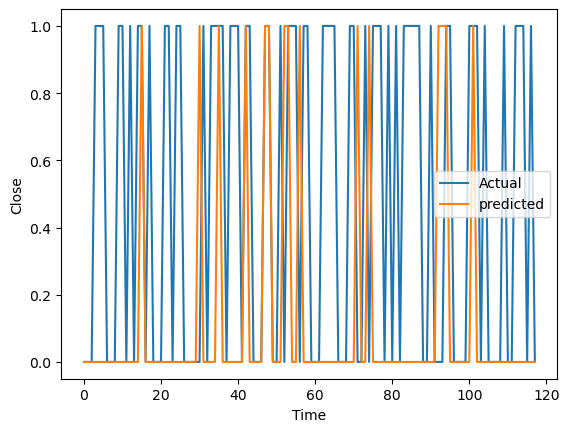

In [307]:
pred=np.where(model.predict(x_test) > 0.5, 1, 0)
predict2 = np.where(pred[:,0] > 0, 0, 1)
shifted_df3=pd.concat([shifted_df["direction"],shifted_df2],axis=1)
test=shifted_df3.iloc[split_index2+n_steps-1:,:]
test['prediction']=predict2
test
hits = pd.DataFrame(np.sign(test["direction"]*test["prediction"])).value_counts()
hits
plt.plot(Y[split_index2:,],label="Actual")
plt.plot(predict2,label='predicted')
plt.xlabel("Time")
plt.ylabel("Close")
plt.legend()
plt.show()

In [308]:
test_out = model.predict(x_test)
test_pred = (test_out > 0.5).astype(int)
test_pred2=np.where(test_pred[:,0] >0,0,1)
test_pred2

4/4 [==============================] - 0s 1ms/step


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0])

In [309]:
test_out = model.predict(x_test)
test_pred = (test_out > 0.5).astype(int)
test_pred2=np.where(test_pred[:,0] >0,0,1)
print("accuracy:", accuracy_score(test_pred2, Y[split_index2:,]))
print("accuracy:", accuracy_score(test_pred, y_test))

print("MAE:", mean_absolute_error(test_pred, y_test))


4/4 [==============================] - 0s 2ms/step
accuracy: 0.5
accuracy: 0.5
MAE: 0.5


In [310]:
model.evaluate(x_test,y_test)


4/4 [==============================] - 0s 3ms/step - loss: 1.2110 - accuracy: 0.5000


[1.2110323905944824, 0.5]

In [311]:
predict2

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0])

In [312]:
"""from sklearn.preprocessing import MinMaxScaler,StandardScaler
scalar=StandardScaler()
shifted_df_as_np=scalar.fit_transform(shifted_df)

shifted_df2=pd.DataFrame(shifted_df_as_np,columns=shifted_df.columns.tolist(),index=shifted_df.index)
split_index=int(len(shifted_df2)*0.80)
split_index2=int(len(shifted_df2)*0.90)
x_train=np.array(shifted_df2.iloc[:split_index,1:]).reshape(-1,shifted_df2.shape[1]-1,1)
x_val=np.array(shifted_df2.iloc[split_index:split_index2,1:]).reshape(-1,shifted_df2.shape[1]-1,1)
x_test=np.array(shifted_df2.iloc[split_index2:,1:]).reshape(-1,shifted_df2.shape[1]-1,1)
y_train=np.array(shifted_df2.iloc[:split_index,0]).reshape(-1,1)
y_val=np.array(shifted_df2.iloc[split_index:split_index2,0]).reshape(-1,1)
y_test=np.array(shifted_df2.iloc[split_index2:,0]).reshape(-1,1)
def set_seeds(seed=100):
    random.seed(seed)
    np.random.seed(seed)


n_steps=1
n_features=x_train.shape[1]



with tf.device('/GPU:0'):
    set_seeds()
    model = Sequential()
    model.add(Conv1D(64,2, activation='relu',input_shape=(n_features,n_steps)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1,activation='softmax'))
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy'])
model.fit(x_train,y_train, verbose=1,shuffle=1,validation_data=(x_val,y_val),batch_size=16,epochs=30)
model.evaluate(x_train,y_train)
"""

"from sklearn.preprocessing import MinMaxScaler,StandardScaler\nscalar=StandardScaler()\nshifted_df_as_np=scalar.fit_transform(shifted_df)\n\nshifted_df2=pd.DataFrame(shifted_df_as_np,columns=shifted_df.columns.tolist(),index=shifted_df.index)\nsplit_index=int(len(shifted_df2)*0.80)\nsplit_index2=int(len(shifted_df2)*0.90)\nx_train=np.array(shifted_df2.iloc[:split_index,1:]).reshape(-1,shifted_df2.shape[1]-1,1)\nx_val=np.array(shifted_df2.iloc[split_index:split_index2,1:]).reshape(-1,shifted_df2.shape[1]-1,1)\nx_test=np.array(shifted_df2.iloc[split_index2:,1:]).reshape(-1,shifted_df2.shape[1]-1,1)\ny_train=np.array(shifted_df2.iloc[:split_index,0]).reshape(-1,1)\ny_val=np.array(shifted_df2.iloc[split_index:split_index2,0]).reshape(-1,1)\ny_test=np.array(shifted_df2.iloc[split_index2:,0]).reshape(-1,1)\ndef set_seeds(seed=100):\n    random.seed(seed)\n    np.random.seed(seed)\n\n\nn_steps=1\nn_features=x_train.shape[1]\n\n\n\nwith tf.device('/GPU:0'):\n    set_seeds()\n    model = Seque

In [313]:
"""test=shifted_df2
test["predict"]=model.predict(x_test)
test=scalar.inverse_transform(test)
pred = np.where(test["predict"] > 0.5, 1, 0)
test['prediction'] = np.where(pred > 0, 1, -1)
hits = pd.DataFrame(np.sign(test["direction"]*test["prediction"])).value_counts()
hits
plt.plot(test["direction"],label="Actual")
plt.plot(test["prediction"],label='predicted')
plt.xlabel("Time")
plt.ylabel("Close")
plt.legend()
plt.show()"""

'test=shifted_df2\ntest["predict"]=model.predict(x_test)\ntest=scalar.inverse_transform(test)\npred = np.where(test["predict"] > 0.5, 1, 0)\ntest[\'prediction\'] = np.where(pred > 0, 1, -1)\nhits = pd.DataFrame(np.sign(test["direction"]*test["prediction"])).value_counts()\nhits\nplt.plot(test["direction"],label="Actual")\nplt.plot(test["prediction"],label=\'predicted\')\nplt.xlabel("Time")\nplt.ylabel("Close")\nplt.legend()\nplt.show()'

In [314]:
"""plt.plot(test["direction"],label="Actual")
plt.plot(test["prediction"],label='predicted')
plt.xlabel("Time")
plt.ylabel("Close")
plt.legend()
plt.show()"""

'plt.plot(test["direction"],label="Actual")\nplt.plot(test["prediction"],label=\'predicted\')\nplt.xlabel("Time")\nplt.ylabel("Close")\nplt.legend()\nplt.show()'

In [315]:
hits = pd.DataFrame(np.sign(test["direction"]*test["prediction"])).value_counts()
hits


0    110
1      8
dtype: int64

In [316]:
hits.values[0] / sum(hits)


0.9322033898305084

In [317]:
hits = pd.DataFrame(np.sign(y_test*test_pred)).value_counts()
hits


0    1  
0.0  0.0    59
1.0  0.0    51
0.0  1.0     8
dtype: int64

In [318]:
hits.values[0] / sum(hits)


0.5